# CNN From Scratch Testing

A simple CNN model to examine its components / architecture and see how it performs inferencing

In [1]:
import cv2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt

## ConvolutionalNeuralNetwork Class as a Pytorch Module

### Parameters
* **num_classes**: Integer values representing the expected number of classes this model will train with
* **kernel_size**: Integer value representing the size of the kernel matrix for convolution
* **max_pool_kernel_size**: Integer value representing the size of the kernel matrix for max pooling

In [2]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes=2, kernel_size=3, max_pool_kernel_size=2):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.max_pool_kernel_size = max_pool_kernel_size
        
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=self.kernel_size)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=self.kernel_size)
        
        self.max_pool1 = nn.MaxPool2d(kernel_size = self.max_pool_kernel_size, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=self.kernel_size)
        
        self.max_pool2 = nn.MaxPool2d(kernel_size = self.max_pool_kernel_size, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, self.num_classes)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        
        out = self.max_pool2(out)
        
        # Flatten things out
        # out = out.reshape(out.shape(0), -1)
        out = out.view(-1, 1600)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        
        return out

## Parameters for the Model

Set the parameters here. If using a CPU, change `device` to `cpu`. If `cont` is set to `True`, then it will expect to load the model file (given by `model_file`) to the model itself.

In [3]:
device         = 'cpu'
cont           = True
model_file     = "cnn-model.pth"
gpu_index      = 0
img_width      = 32
img_height     = 32
img_file       = "/home/ralampay/Desktop/boy.png"

num_classes          = 2
kernel_size          = 3
max_pool_kernel_size = 2

In [4]:
if device == 'cuda':
    print("CUDA Device: {}".format(torch.cuda.get_device_name(gpu_index)))
    device = "cuda:{}".format(gpu_index)

model = ConvolutionalNeuralNetwork(
    num_classes=num_classes, 
    kernel_size=kernel_size, 
    max_pool_kernel_size=max_pool_kernel_size
).to(device)

if cont:
    print("Loading model from {}".format(model_file))
    state = torch.load(model_file)
    model.load_state_dict(state['state_dict'])
    model.optimizer = state['optimizer']

Loading model from cnn-model.pth


## Test

Performs a forward pass to a given image. The image is first resized according to `img_width` and `img_height`.

Notes:
1. OpenCV `img = cv2.imread(path)` loads an image with HWC-layout `(height, width, channels)`, while Pytorch requires CHW-layout. So we have to do `np.transpose(image,(2,0,1))` for HWC->CHW transformation.
2. Image is normalized first (`img / 255`) for better scaling.
3. Make sure to load the tensor as an array since the forward pass of the network expects to receive more than one input `x`

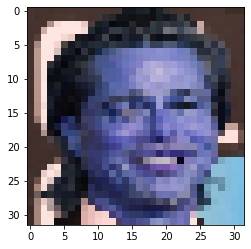

/tmp/ipykernel_59982/3232074944.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  img = torch.Tensor([img]).to(device)


In [5]:
dim = (img_width, img_height)

img = cv2.imread(img_file)
img = cv2.resize(img, dim)
img = img / 255

plt.imshow(img)
plt.show()

img = img.transpose((2, 0, 1)) 

img = torch.Tensor([img]).to(device)

In [6]:
y = model.forward(img)

y

tensor([[ 7.2554, -5.9028]], grad_fn=<AddmmBackward0>)

In [7]:
# Girl -> [0, 1]
# Boy -> [1, 0]

# Alligator Crack --> [1, 0, 0, 0]
# Long Crack --> [0, 1, 0, 0]
# Lat Crack --> [0, 0, 1, 0]
# Others --> [0, 0, 0, 1]